<a href="https://colab.research.google.com/github/ashwinsaba/CAI-Development/blob/master/CBD_Dev_Nov_data_Create_question_and_student_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create student clusters on the basis of performance and writing behavior using hyerarchical clustering

---



##Introduction

The purpose of this notebook is to design the logic for the Cognitive and Behavioral Diagnostics module of C.AI. For this purpose, the high-level approach we are undertaking is nested:

***Categorize Questions --> Categorize students based on question categories***

We will discuss the approach in detail towards the end of the notebook.

## Data Prepararion

In [1]:
#Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import os
warnings.filterwarnings("ignore")
from functools import reduce
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, ward, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#Import the clean dataset

raw1=pd.read_csv('/content/drive/My Drive/cai_data/student_testing_data_nov_2018_master.csv',index_col=0)
raw1['TEST_ID'] = raw1['TEST_ID'].astype(str)
raw1['QUESTION_ID'] = raw1['QUESTION_ID'].astype(str)
raw1['STUDENT_ID'] = raw1['STUDENT_ID'].astype(str)
raw1.describe()

,RESPONSE,TOTAL_TIME,INITIAL_TIME,SOLVE_TIME,DELAYS_HIGHER_1S,STROKE_COUNT,DELAY_1S,DELAY_2S,DELAY_3S,DELAY_4S,...,TOTAL_INK_LENGTH,AVERAGE_SPEED,INITIATION_SPEED,TERMINATION_SPEED,REWORK,TOTAL_DELAY_1S,SOLVING_TIME_PRESET,QUESTION_SCORE,CORRECT_RATE_PRESET,COUNT_USED_PRESET
count,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,...,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,31400.000000,29716.000000,31400.000000
mean,0.562739,99.378599,27.397803,39.170924,7.116083,62.624204,2.904490,0.708949,0.910510,0.333631,...,52.956903,0.696842,0.742669,0.755415,0.154873,87.605478,1.634713,5.375127,57.035432,52.653057
std,0.496056,104.751543,29.432468,40.118483,22.424971,69.749816,7.036452,2.276159,3.141455,1.210626,...,59.777803,0.589259,0.740672,0.832345,0.507903,86.774693,20.484739,2.698016,28.908414,55.705493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,26.000000,9.000000,10.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,...,11.150000,0.270000,0.170000,0.100000,0.000000,28.000000,0.000000,4.000000,34.000000,13.000000
50%,1.000000,67.000000,17.000000,27.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,33.325000,0.550000,0.520000,0.480000,0.000000,61.000000,0.000000,4.000000,60.200000,29.000000
75%,1.000000,138.000000,34.000000,54.000000,2.000000,86.000000,2.000000,0.000000,0.000000,0.000000,...,72.182500,0.970000,1.110000,1.140000,0.000000,120.000000,0.000000,6.000000,80.400000,71.000000
max,1.000000,684.000000,210.000000,251.000000,247.000000,459.000000,65.000000,22.000000,32.000000,12.000000,...,393.280000,3.570000,4.160000,4.880000,4.000000,764.000000,600.000000,25.000000,100.000000,178.000000


In [3]:
# Subset only the tests with more than 10 questions

test_df1=raw1.groupby(['TEST_ID'])[['QUESTION_ID']].nunique().reset_index()
test_df1=test_df1.rename(columns={'QUESTION_ID':'NUM_OF_QUESTIONS'})
long_tests=test_df1['TEST_ID'][(test_df1['NUM_OF_QUESTIONS']>10)]
raw2=raw1[raw1.TEST_ID.isin(long_tests)]
raw2.describe()

#31,400 --> 30,281

,RESPONSE,TOTAL_TIME,INITIAL_TIME,SOLVE_TIME,DELAYS_HIGHER_1S,STROKE_COUNT,DELAY_1S,DELAY_2S,DELAY_3S,DELAY_4S,...,TOTAL_INK_LENGTH,AVERAGE_SPEED,INITIATION_SPEED,TERMINATION_SPEED,REWORK,TOTAL_DELAY_1S,SOLVING_TIME_PRESET,QUESTION_SCORE,CORRECT_RATE_PRESET,COUNT_USED_PRESET
count,30281.000000,30281.000000,30281.000000,30281.000000,30281.000000,30281.000000,30281.000000,30281.000000,30281.000000,30281.000000,...,30281.000000,30281.000000,30281.000000,30281.000000,30281.000000,30281.000000,30281.000000,30281.000000,28765.000000,30281.000000
mean,0.561507,99.133978,27.310723,38.961395,6.853770,61.823289,2.766817,0.679832,0.877844,0.322942,...,52.504908,0.690114,0.736184,0.749039,0.148872,87.483306,0.758892,5.315445,56.782399,54.161025
std,0.496211,104.257015,29.269624,39.964939,22.161115,68.964611,6.861217,2.251133,3.120378,1.204940,...,59.606018,0.584941,0.738194,0.828105,0.499831,86.245615,11.673340,2.568011,28.823181,56.089562
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,26.000000,9.000000,10.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,...,10.990000,0.260000,0.160000,0.100000,0.000000,28.000000,0.000000,4.000000,33.400000,15.000000
50%,1.000000,67.000000,17.000000,27.000000,0.000000,39.000000,0.000000,0.000000,0.000000,0.000000,...,32.800000,0.540000,0.510000,0.470000,0.000000,61.000000,0.000000,4.000000,60.000000,31.000000
75%,1.000000,138.000000,34.000000,54.000000,2.000000,85.000000,2.000000,0.000000,0.000000,0.000000,...,71.340000,0.960000,1.100000,1.130000,0.000000,120.000000,0.000000,6.000000,80.000000,71.000000
max,1.000000,684.000000,210.000000,250.000000,246.000000,459.000000,65.000000,22.000000,32.000000,12.000000,...,393.280000,3.570000,4.160000,4.880000,4.000000,764.000000,300.000000,10.000000,100.000000,178.000000


In [4]:
# Subset only the students who have answered a reasonable number of questions

studentcount_df=raw1.groupby(['STUDENT_ID'])[['QUESTION_ID']].nunique().reset_index()
studentcount_df=studentcount_df.rename(columns={'QUESTION_ID':'NUM_OF_QUESTIONS'})
long_students=studentcount_df['STUDENT_ID'][(studentcount_df['NUM_OF_QUESTIONS']>20)]
raw3=raw2[raw2.STUDENT_ID.isin(long_students)]
input_df=raw3.copy()
input_df.describe()

#30,281 --> 22,844

,RESPONSE,TOTAL_TIME,INITIAL_TIME,SOLVE_TIME,DELAYS_HIGHER_1S,STROKE_COUNT,DELAY_1S,DELAY_2S,DELAY_3S,DELAY_4S,...,TOTAL_INK_LENGTH,AVERAGE_SPEED,INITIATION_SPEED,TERMINATION_SPEED,REWORK,TOTAL_DELAY_1S,SOLVING_TIME_PRESET,QUESTION_SCORE,CORRECT_RATE_PRESET,COUNT_USED_PRESET
count,22844.000000,22844.000000,22844.000000,22844.000000,22844.000000,22844.000000,22844.000000,22844.000000,22844.000000,22844.000000,...,22844.000000,22844.000000,22844.000000,22844.000000,22844.000000,22844.000000,22844.000000,22844.000000,21633.000000,22844.000000
mean,0.528366,100.365304,27.902600,38.938233,6.939196,61.966600,2.897347,0.688977,0.882245,0.321923,...,52.523988,0.681702,0.732444,0.753461,0.149361,89.329671,0.843110,4.205831,53.083151,61.396209
std,0.499206,104.520009,29.673871,39.995309,21.679244,69.109391,6.880574,2.206448,3.070529,1.183704,...,59.313644,0.583081,0.735310,0.830985,0.486043,86.608351,12.316084,1.435111,28.193976,60.165714
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,27.000000,9.000000,10.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,...,10.837500,0.260000,0.160000,0.110000,0.000000,30.000000,0.000000,4.000000,30.500000,17.000000
50%,1.000000,69.000000,18.000000,27.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,33.250000,0.530000,0.510000,0.480000,0.000000,63.000000,0.000000,4.000000,56.100000,32.000000
75%,1.000000,140.000000,36.000000,54.000000,3.000000,85.000000,2.000000,0.000000,0.000000,0.000000,...,72.107500,0.950000,1.090000,1.130000,0.000000,122.000000,0.000000,4.000000,76.400000,110.000000
max,1.000000,684.000000,209.000000,250.000000,246.000000,459.000000,65.000000,22.000000,32.000000,12.000000,...,393.280000,3.570000,4.160000,4.880000,4.000000,652.000000,300.000000,10.000000,100.000000,178.000000


## Categorizing Questions - Hierarchical Clustering

####**1. By mean TOTAL_TIME for correct responses**

In [0]:
# First, defining the function for Fancy Dendogram

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(15,10))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [0]:
from sklearn.metrics.pairwise import euclidean_distances

def gap_stat(data,label):
    k = len(np.unique(label))
    n = data.shape[0]
    p = data.shape[1]
    D_r = []
    C_r = []
    for label_number in range(0,k):
        this_label_index = np.where(label==label_number)[0]
        temp_sum = 0
        pairwise_distance_matrix = euclidean_distances(data[this_label_index],squared=True)
        D_r.append(np.sum(pairwise_distance_matrix))
        C_r.append(float(len(this_label_index)))

    W_r = np.sum(np.asarray(D_r)/(2*np.asarray(C_r)))
    gap_stats = np.log(float(p*n)/12)-(2/float(p))*np.log(k)- np.log(W_r)
    return(gap_stats)

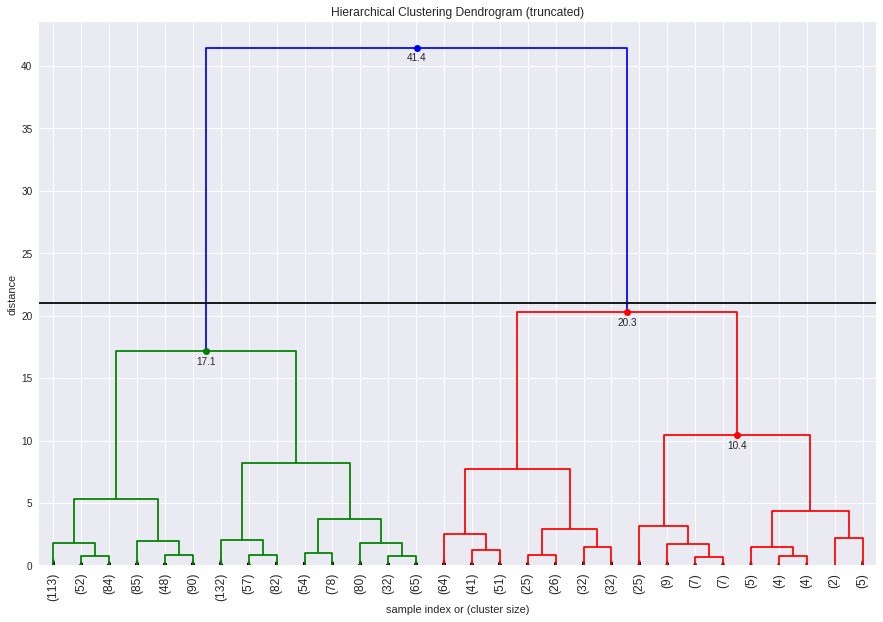

In [7]:

correct_df=input_df.loc[input_df['RESPONSE'] == 1]
question_df1=correct_df.groupby(['QUESTION_ID'])['TOTAL_TIME'].mean().reset_index()
question_df1=question_df1.rename(columns={'TOTAL_TIME':'TOTAL_TIME_CORRECT'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df1[['TOTAL_TIME_CORRECT']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=21
)

plt.show()

In [8]:
max_d = 21

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df1['CORRECT_TOTAL_TIME_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE TOTAL TIME FOR CORRECT RESPONSES: {}'.format(round(question_df1[question_df1['CORRECT_TOTAL_TIME_CLUSTER'] == i].TOTAL_TIME_CORRECT.mean(), 2)))

Clusters Summary


label: 1
n: 1052
AVERAGE TOTAL TIME FOR CORRECT RESPONSES: 62.37

label: 2
n: 339
AVERAGE TOTAL TIME FOR CORRECT RESPONSES: 209.16


In [0]:
question_df1.loc[question_df1['CORRECT_TOTAL_TIME_CLUSTER'] == 1, 'CORRECT_TOTAL_TIME_FLAG'] = 'LOW'
question_df1.loc[question_df1['CORRECT_TOTAL_TIME_CLUSTER'] == 2, 'CORRECT_TOTAL_TIME_FLAG'] = 'HIGH'

In [10]:
X = question_df1[['TOTAL_TIME_CORRECT']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.6730612473614093

####**2. By mean TOTAL_TIME for wrong responses**

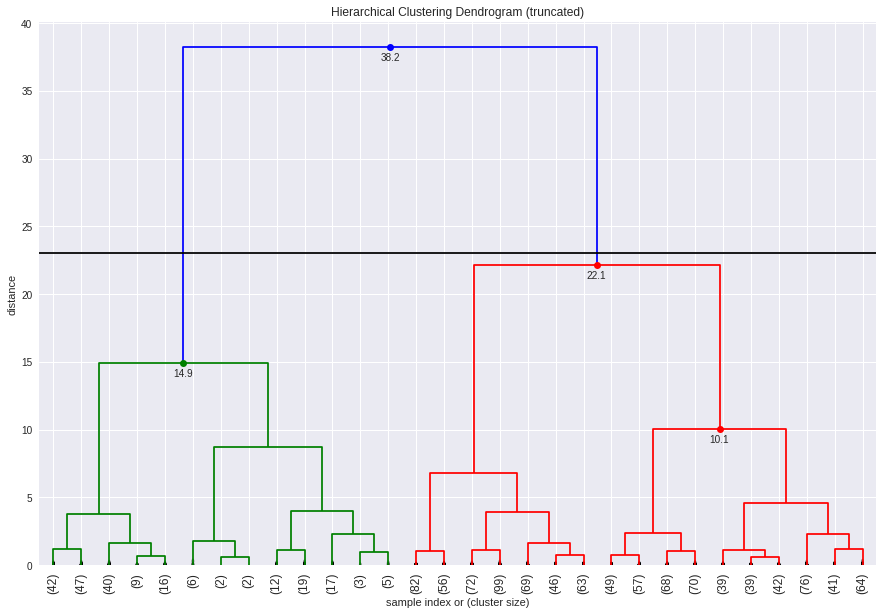

In [11]:
wrong_df=input_df.loc[input_df['RESPONSE'] == 0]
question_df2=wrong_df.groupby(['QUESTION_ID'])['TOTAL_TIME'].mean().reset_index()
question_df2=question_df2.rename(columns={'TOTAL_TIME':'TOTAL_TIME_WRONG'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df2[['TOTAL_TIME_WRONG']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=23
)

plt.show()

In [12]:
max_d = 23

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df2['WRONG_TOTAL_TIME_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('TOTAL TIME FOR WRONG RESPONSES: {}'.format(round(question_df2[question_df2['WRONG_TOTAL_TIME_CLUSTER'] == i].TOTAL_TIME_WRONG.mean(), 2)))

Clusters Summary


label: 1
n: 220
TOTAL TIME FOR WRONG RESPONSES: 253.52

label: 2
n: 1032
TOTAL TIME FOR WRONG RESPONSES: 79.89


In [0]:
question_df2.loc[question_df2['WRONG_TOTAL_TIME_CLUSTER'] == 1, 'WRONG_TOTAL_TIME_FLAG'] = 'HIGH'
question_df2.loc[question_df2['WRONG_TOTAL_TIME_CLUSTER'] == 2, 'WRONG_TOTAL_TIME_FLAG'] = 'LOW'

In [14]:
X = question_df2[['TOTAL_TIME_WRONG']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.7279921329109198

####**3. By mean success rate (to gauge difficulty level)**

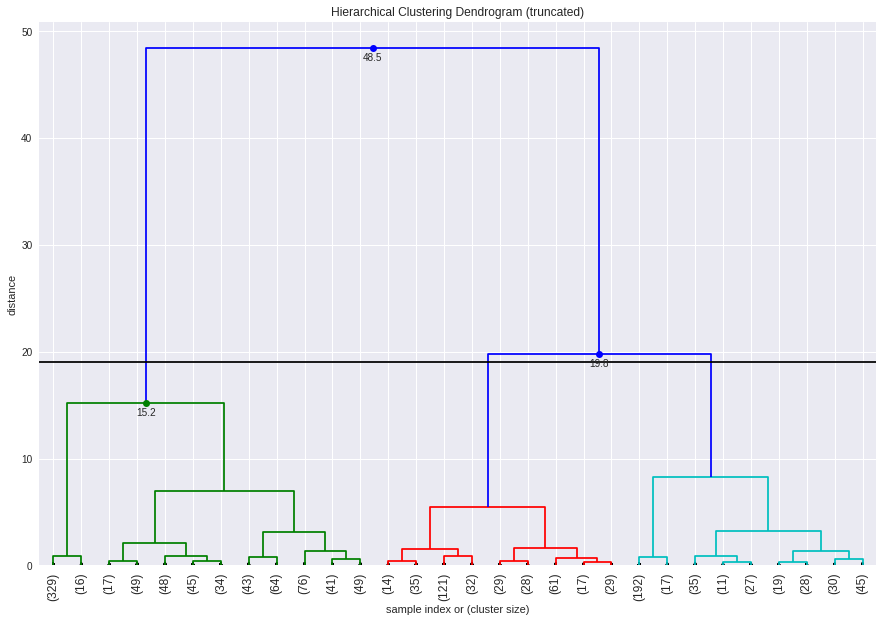

In [57]:
question_df3=input_df.groupby(['QUESTION_ID'])['RESPONSE'].mean().reset_index()
question_df3=question_df3.rename(columns={'RESPONSE':'CORRECT_RATE'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df3[['CORRECT_RATE']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=19
)

plt.show()

In [16]:
max_d = 19

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df3['CORRECT_RATE_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('CORRECT RATE: {}'.format(round(question_df3[question_df3['CORRECT_RATE_CLUSTER'] == i].CORRECT_RATE.mean(), 2)))

Clusters Summary


label: 1
n: 811
CORRECT RATE: 0.85

label: 2
n: 366
CORRECT RATE: 0.44

label: 3
n: 404
CORRECT RATE: 0.1


In [0]:
question_df3.loc[question_df3['CORRECT_RATE_CLUSTER'] == 1, 'DIFFICULTY_FLAG'] = 'LOW'
question_df3.loc[question_df3['CORRECT_RATE_CLUSTER'] == 2, 'DIFFICULTY_FLAG'] = 'MED'
question_df3.loc[question_df3['CORRECT_RATE_CLUSTER'] == 3, 'DIFFICULTY_FLAG'] = 'HIGH'

In [18]:
# Validation

X = question_df3[['CORRECT_RATE']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.49792749141154496

####**4. By mean TOTAL_DELAY_1S for correct responses**

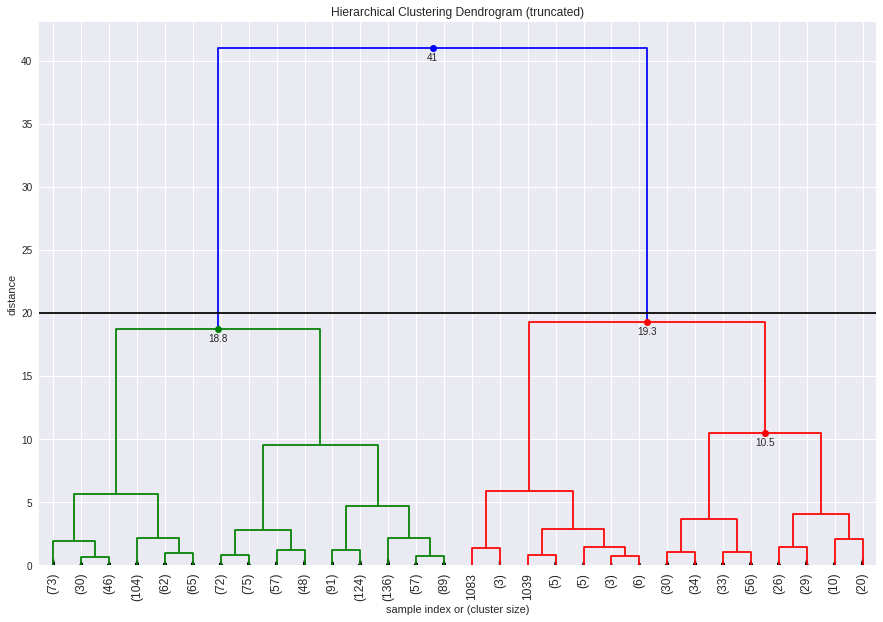

In [19]:
question_df4=correct_df.groupby(['QUESTION_ID'])['TOTAL_DELAY_1S'].mean().reset_index()
question_df4=question_df4.rename(columns={'TOTAL_DELAY_1S':'TOTAL_DELAY_1S_CORRECT'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df4[['TOTAL_DELAY_1S_CORRECT']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=20
)

plt.show()

In [20]:
max_d = 20

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df4['CORRECT_DELAY_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE DELAY COUNT FOR CORRECT RESPONSES: {}'.format(round(question_df4[question_df4['CORRECT_DELAY_CLUSTER'] == i].TOTAL_DELAY_1S_CORRECT.mean(), 2)))

Clusters Summary


label: 1
n: 1129
AVERAGE DELAY COUNT FOR CORRECT RESPONSES: 59.35

label: 2
n: 262
AVERAGE DELAY COUNT FOR CORRECT RESPONSES: 183.2


In [0]:
question_df4.loc[question_df4['CORRECT_DELAY_CLUSTER'] == 1, 'CORRECT_DELAY_FLAG'] = 'LOW'
question_df4.loc[question_df4['CORRECT_DELAY_CLUSTER'] == 2, 'CORRECT_DELAY_FLAG'] = 'HIGH'

In [22]:
# Validation

X = question_df4[['TOTAL_DELAY_1S_CORRECT']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.7579108094264153

####**5. By mean TOTAL_DELAY_1S for wrong responses**

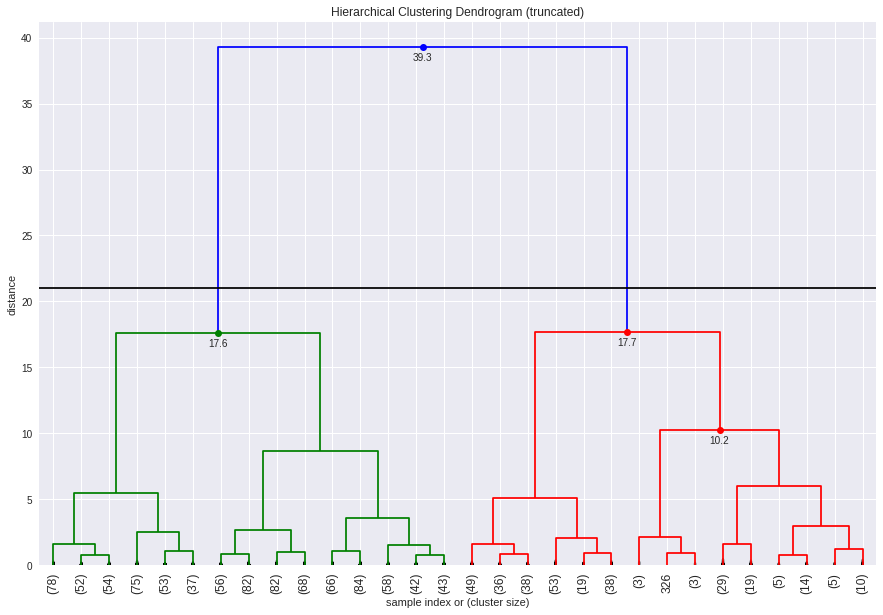

In [23]:
question_df5=wrong_df.groupby(['QUESTION_ID'])['TOTAL_DELAY_1S'].mean().reset_index()
question_df5=question_df5.rename(columns={'TOTAL_DELAY_1S':'TOTAL_DELAY_1S_WRONG'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df5[['TOTAL_DELAY_1S_WRONG']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=21
)

plt.show()

In [24]:
max_d = 21

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df5['WRONG_DELAY_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE DELAY COUNT FOR WRONG RESPONSES: {}'.format(round(question_df5[question_df5['WRONG_DELAY_CLUSTER'] == i].TOTAL_DELAY_1S_WRONG.mean(), 2)))

Clusters Summary


label: 1
n: 930
AVERAGE DELAY COUNT FOR WRONG RESPONSES: 68.14

label: 2
n: 322
AVERAGE DELAY COUNT FOR WRONG RESPONSES: 197.04


In [0]:
question_df5.loc[question_df5['WRONG_DELAY_CLUSTER'] == 1, 'WRONG_DELAY_FLAG'] = 'LOW'
question_df5.loc[question_df5['WRONG_DELAY_CLUSTER'] == 2, 'WRONG_DELAY_FLAG'] = 'HIGH'

In [26]:
# Validation

X = question_df5[['TOTAL_DELAY_1S_WRONG']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.6555195684860536

####**6. By average speed for correct responses**

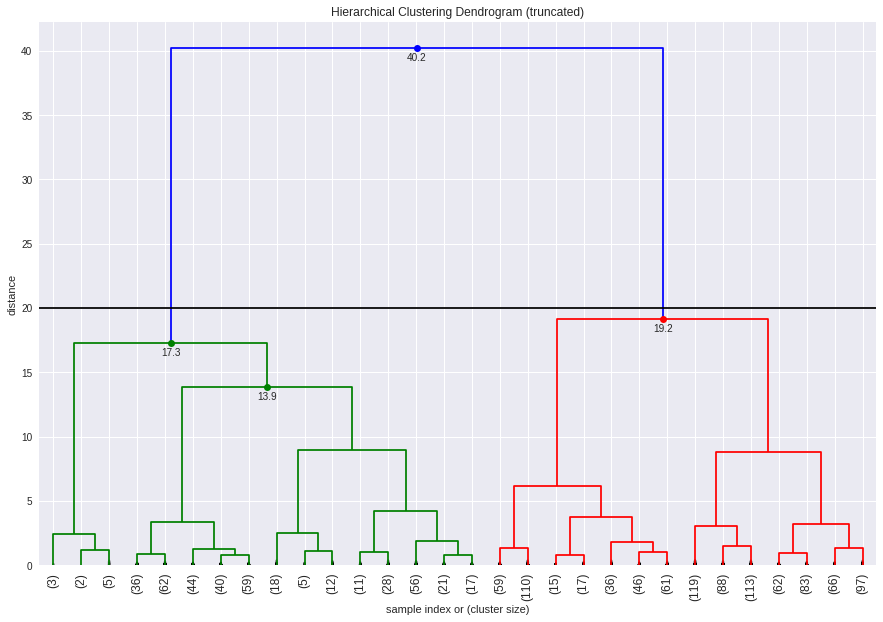

In [27]:
question_df6=correct_df.groupby(['QUESTION_ID'])['AVERAGE_SPEED'].mean().reset_index()
question_df6=question_df6.rename(columns={'AVERAGE_SPEED':'AVERAGE_SPEED_CORRECT'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df6[['AVERAGE_SPEED_CORRECT']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=20
)

plt.show()

In [28]:
max_d = 20

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df6['CORRECT_SPEED_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE SPEED FOR CORRECT RESPONSES: {}'.format(round(question_df6[question_df6['CORRECT_SPEED_CLUSTER'] == i].AVERAGE_SPEED_CORRECT.mean(), 2)))

Clusters Summary


label: 1
n: 419
AVERAGE SPEED FOR CORRECT RESPONSES: 1.36

label: 2
n: 972
AVERAGE SPEED FOR CORRECT RESPONSES: 0.61


In [0]:
question_df6.loc[question_df6['CORRECT_SPEED_CLUSTER'] == 1, 'CORRECT_SPEED_FLAG'] = 'HIGH'
question_df6.loc[question_df6['CORRECT_SPEED_CLUSTER'] == 2, 'CORRECT_SPEED_FLAG'] = 'LOW'

In [30]:
# Validation

X = question_df6[['AVERAGE_SPEED_CORRECT']].as_matrix()
# generate the linkage matrix
single_link = linkage(X, 'single') # using single link metric to evaluate 'distance' between clusters
c, coph_dists = cophenet(single_link, pdist(X))
c

0.6903595033459059

####7. By average speed for wrong responses

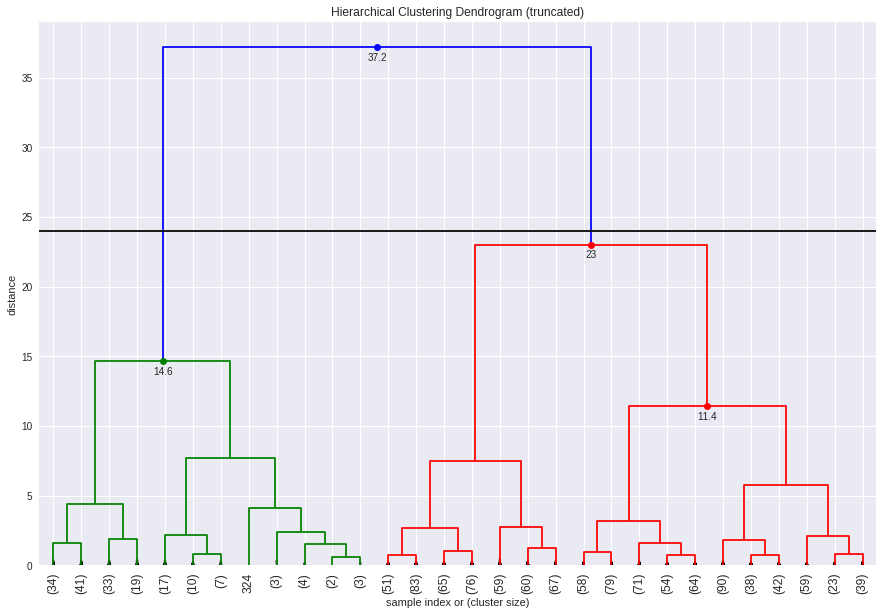

In [31]:
question_df7=wrong_df.groupby(['QUESTION_ID'])['AVERAGE_SPEED'].mean().reset_index()
question_df7=question_df7.rename(columns={'AVERAGE_SPEED':'AVERAGE_SPEED_WRONG'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df7[['AVERAGE_SPEED_WRONG']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=24
)

plt.show()

In [32]:
max_d = 24

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df7['WRONG_SPEED_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE SPEED FOR WRONG RESPONSES: {}'.format(round(question_df7[question_df7['WRONG_SPEED_CLUSTER'] == i].AVERAGE_SPEED_WRONG.mean(), 2)))

Clusters Summary


label: 1
n: 174
AVERAGE SPEED FOR WRONG RESPONSES: 1.36

label: 2
n: 1078
AVERAGE SPEED FOR WRONG RESPONSES: 0.49


In [0]:
question_df7.loc[question_df7['WRONG_SPEED_CLUSTER'] == 1, 'WRONG_SPEED_FLAG'] = 'HIGH'
question_df7.loc[question_df7['WRONG_SPEED_CLUSTER'] == 2, 'WRONG_SPEED_FLAG'] = 'LOW'

####8. By average stroke count for correct responses

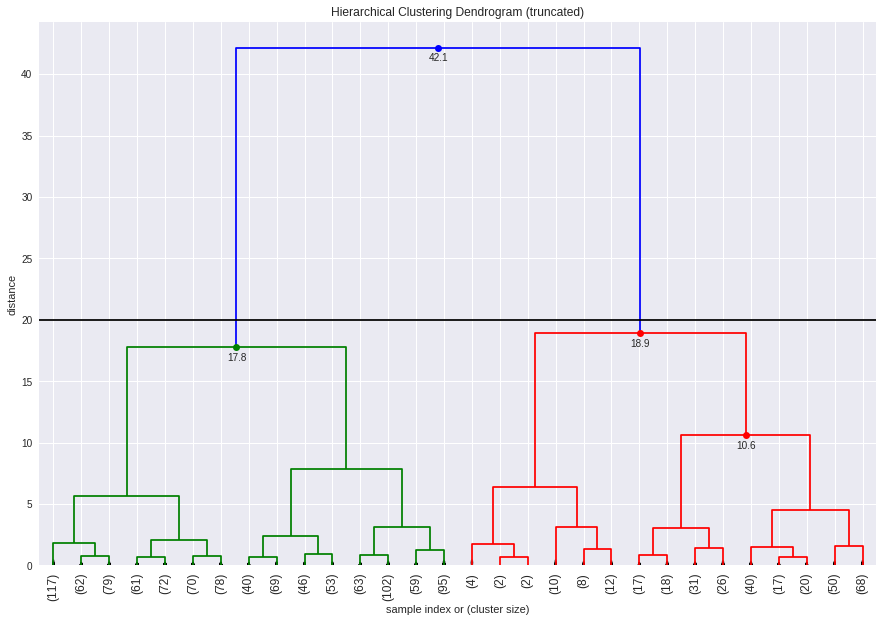

In [34]:
question_df8=correct_df.groupby(['QUESTION_ID'])['STROKE_COUNT'].mean().reset_index()
question_df8=question_df8.rename(columns={'STROKE_COUNT':'STROKE_COUNT_CORRECT'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df8[['STROKE_COUNT_CORRECT']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=20
)

plt.show()

In [35]:
max_d = 20

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df8['STROKE_COUNT_CORRECT_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('STROKE COUNT FOR CORRECT RESPONSES: {}'.format(round(question_df8[question_df8['STROKE_COUNT_CORRECT_CLUSTER'] == i].STROKE_COUNT_CORRECT.mean(), 2)))

Clusters Summary


label: 1
n: 1066
STROKE COUNT FOR CORRECT RESPONSES: 45.95

label: 2
n: 325
STROKE COUNT FOR CORRECT RESPONSES: 166.33


In [0]:
question_df8.loc[question_df8['STROKE_COUNT_CORRECT_CLUSTER'] == 1, 'STROKE_COUNT_CORRECT_FLAG'] = 'LOW'
question_df8.loc[question_df8['STROKE_COUNT_CORRECT_CLUSTER'] == 2, 'STROKE_COUNT_CORRECT_FLAG'] = 'HIGH'

####9. By average stroke count for wrong responses

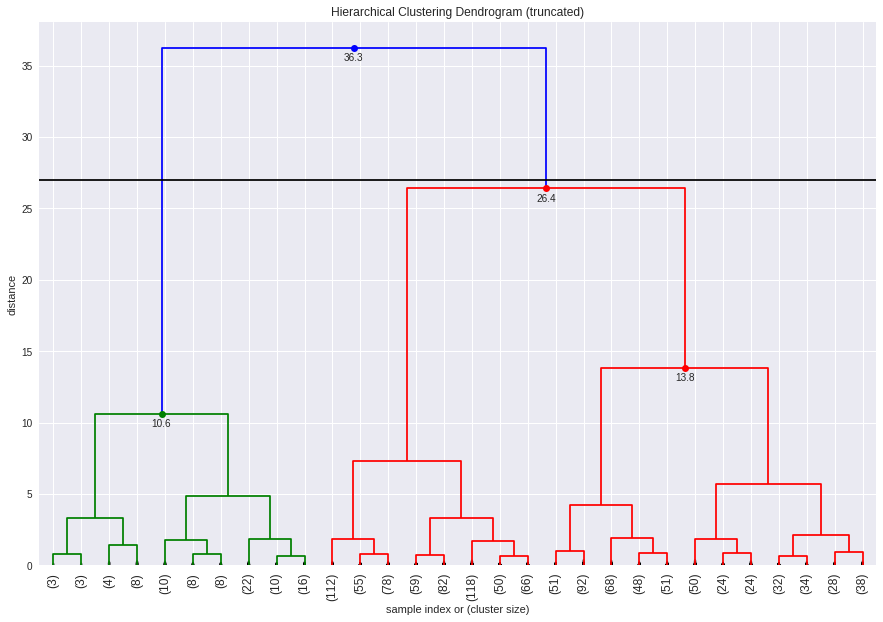

In [37]:
question_df9=wrong_df.groupby(['QUESTION_ID'])['STROKE_COUNT'].mean().reset_index()
question_df9=question_df9.rename(columns={'STROKE_COUNT':'STROKE_COUNT_WRONG'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df9[['STROKE_COUNT_WRONG']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=27
)

plt.show()

In [38]:
max_d = 27

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df9['STROKE_COUNT_WRONG_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('STROKE COUNT FOR WRONG RESPONSES: {}'.format(round(question_df9[question_df9['STROKE_COUNT_WRONG_CLUSTER'] == i].STROKE_COUNT_WRONG.mean(), 2)))

Clusters Summary


label: 1
n: 92
STROKE COUNT FOR WRONG RESPONSES: 204.01

label: 2
n: 1160
STROKE COUNT FOR WRONG RESPONSES: 49.19


In [0]:
question_df9.loc[question_df9['STROKE_COUNT_WRONG_CLUSTER'] == 1, 'STROKE_COUNT_WRONG_FLAG'] = 'HIGH'
question_df9.loc[question_df9['STROKE_COUNT_WRONG_CLUSTER'] == 2, 'STROKE_COUNT_WRONG_FLAG'] = 'LOW'

####10. By average ink length for correct answers

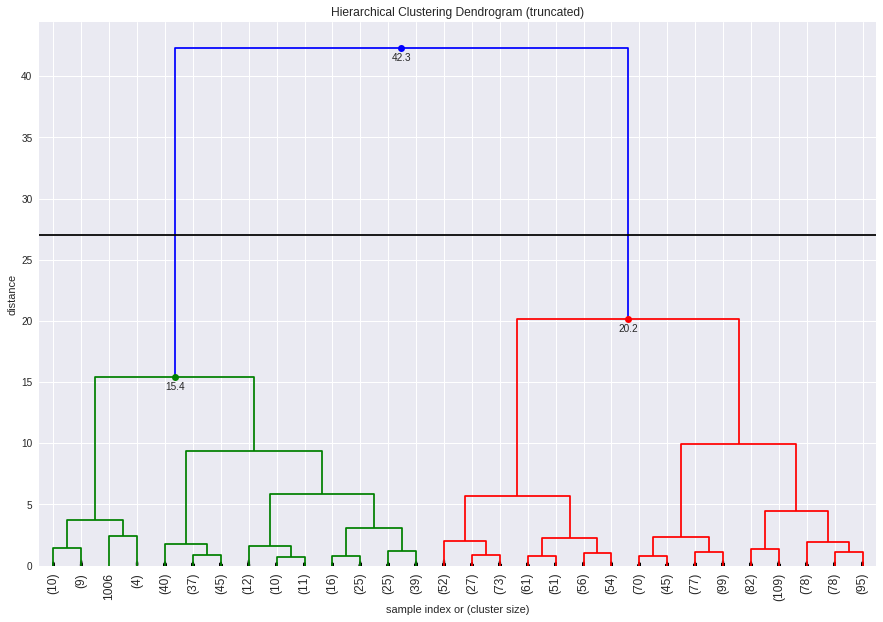

In [40]:
question_df10=correct_df.groupby(['QUESTION_ID'])['TOTAL_INK_LENGTH'].mean().reset_index()
question_df10=question_df10.rename(columns={'TOTAL_INK_LENGTH':'TOTAL_INK_LENGTH_CORRECT'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df10[['TOTAL_INK_LENGTH_CORRECT']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=27
)

plt.show()

In [41]:
max_d = 27

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df10['TOTAL_INK_LENGTH_CORRECT_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('INK LENGTH FOR CORRECT RESPONSES: {}'.format(round(question_df10[question_df10['TOTAL_INK_LENGTH_CORRECT_CLUSTER'] == i].TOTAL_INK_LENGTH_CORRECT.mean(), 2)))

Clusters Summary


label: 1
n: 284
INK LENGTH FOR CORRECT RESPONSES: 140.1

label: 2
n: 1107
INK LENGTH FOR CORRECT RESPONSES: 42.1


In [0]:
question_df10.loc[question_df10['TOTAL_INK_LENGTH_CORRECT_CLUSTER'] == 1, 'TOTAL_INK_LENGTH_CORRECT_FLAG'] = 'HIGH'
question_df10.loc[question_df10['TOTAL_INK_LENGTH_CORRECT_CLUSTER'] == 2, 'TOTAL_INK_LENGTH_CORRECT_FLAG'] = 'LOW'

####11. By average ink length for wrong responses

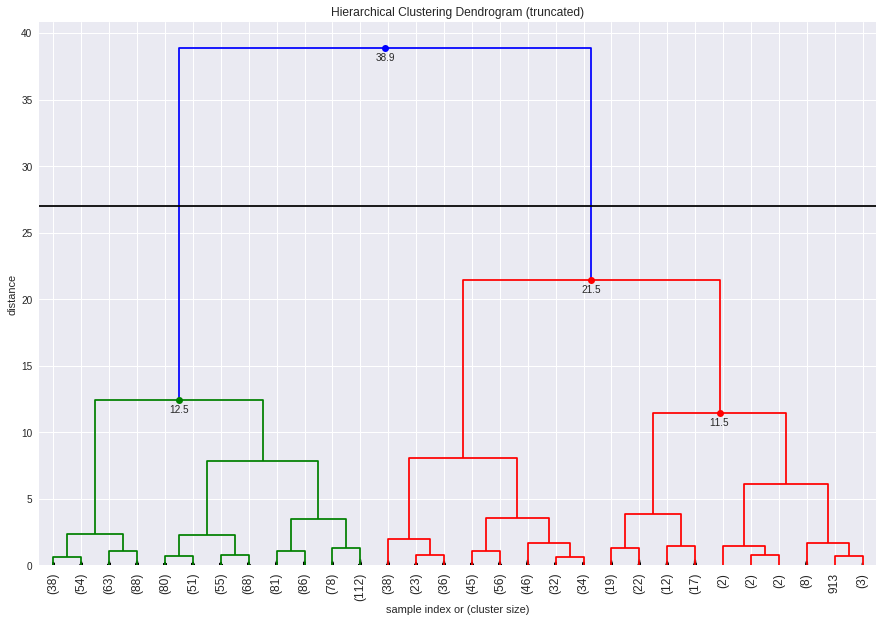

In [43]:
question_df11=wrong_df.groupby(['QUESTION_ID'])['TOTAL_INK_LENGTH'].mean().reset_index()
question_df11=question_df11.rename(columns={'TOTAL_INK_LENGTH':'TOTAL_INK_LENGTH_WRONG'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(question_df11[['TOTAL_INK_LENGTH_WRONG']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=27
)

plt.show()

In [44]:
max_d = 27

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

question_df11['TOTAL_INK_LENGTH_WRONG_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('INK LENGTH FOR WRONG RESPONSES: {}'.format(round(question_df11[question_df11['TOTAL_INK_LENGTH_WRONG_CLUSTER'] == i].TOTAL_INK_LENGTH_WRONG.mean(), 2)))

Clusters Summary


label: 1
n: 854
INK LENGTH FOR WRONG RESPONSES: 28.57

label: 2
n: 398
INK LENGTH FOR WRONG RESPONSES: 108.45


In [0]:
question_df11.loc[question_df11['TOTAL_INK_LENGTH_WRONG_CLUSTER'] == 1, 'TOTAL_INK_LENGTH_WRONG_FLAG'] = 'LOW'
question_df11.loc[question_df11['TOTAL_INK_LENGTH_WRONG_CLUSTER'] == 2, 'TOTAL_INK_LENGTH_WRONG_FLAG'] = 'HIGH'

### Merging all the flags into one table

In [46]:
question_df_list = [question_df1,question_df2,question_df3,question_df4,question_df5,question_df6,question_df7]
question_df_all = reduce(lambda left,right: pd.merge(left,right,on=['QUESTION_ID']), question_df_list)
question_df_all.head()

,QUESTION_ID,TOTAL_TIME_CORRECT,CORRECT_TOTAL_TIME_CLUSTER,CORRECT_TOTAL_TIME_FLAG,TOTAL_TIME_WRONG,WRONG_TOTAL_TIME_CLUSTER,WRONG_TOTAL_TIME_FLAG,CORRECT_RATE,CORRECT_RATE_CLUSTER,DIFFICULTY_FLAG,...,CORRECT_DELAY_FLAG,TOTAL_DELAY_1S_WRONG,WRONG_DELAY_CLUSTER,WRONG_DELAY_FLAG,AVERAGE_SPEED_CORRECT,CORRECT_SPEED_CLUSTER,CORRECT_SPEED_FLAG,AVERAGE_SPEED_WRONG,WRONG_SPEED_CLUSTER,WRONG_SPEED_FLAG
0,10007,169.562500,2,HIGH,273.090909,1,HIGH,0.592593,1,LOW,...,HIGH,216.545455,2,HIGH,0.544375,2,LOW,0.246364,2,LOW
1,10010,95.833333,1,LOW,178.000000,2,LOW,0.666667,1,LOW,...,LOW,167.000000,2,HIGH,0.406667,2,LOW,0.200000,2,LOW
2,10014,88.047619,1,LOW,137.125000,2,LOW,0.724138,1,LOW,...,LOW,130.500000,1,LOW,0.661905,2,LOW,0.577500,2,LOW
3,10015,151.500000,2,HIGH,79.000000,2,LOW,0.222222,3,HIGH,...,LOW,59.000000,1,LOW,0.820000,2,LOW,0.405714,2,LOW
4,10016,71.200000,1,LOW,57.000000,2,LOW,0.555556,2,MED,...,LOW,127.250000,1,LOW,0.688000,2,LOW,0.955000,2,LOW


In [0]:
#input_df.to_csv('/content/drive/My Drive/cai_data/question_clusters.csv',index = True)

Text(0.5,0,'')

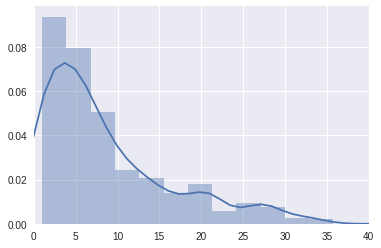

In [48]:
test=input_df.groupby(['QUESTION_ID'])['STUDENT_ID'].agg('nunique').reset_index()
test.sort_values('STUDENT_ID', ascending=False)
q_dist=sns.distplot(test['STUDENT_ID']);
q_dist.set_xlim(0,40)
q_dist.set_xlabel('')

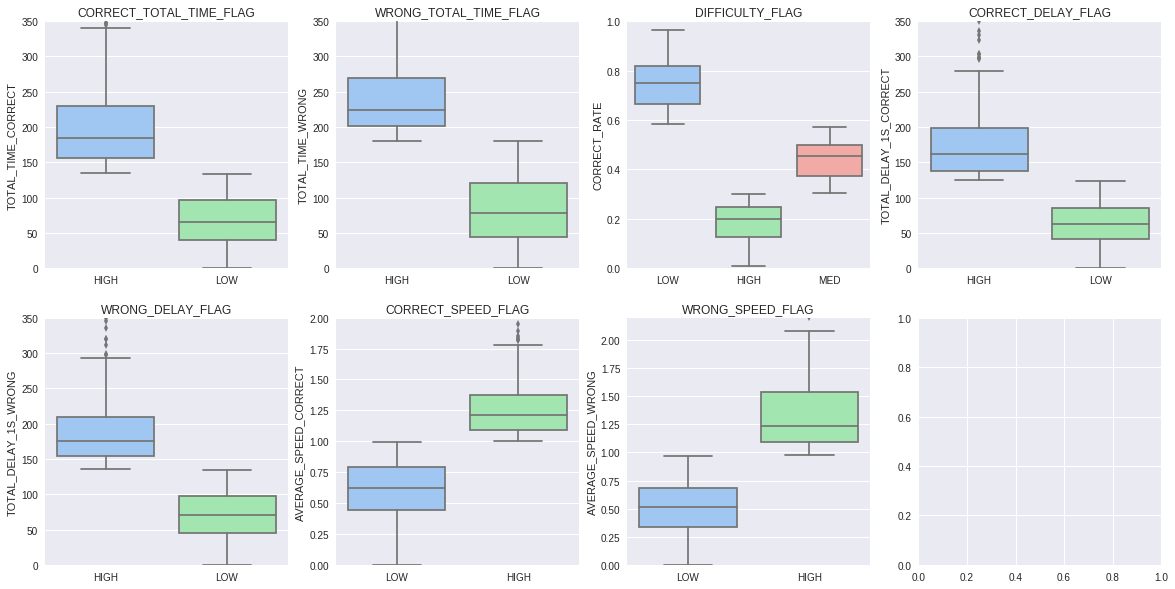

In [49]:
f, axes = plt.subplots(nrows=2,ncols=4,figsize=(20,10))

ax1 = sns.boxplot(x="CORRECT_TOTAL_TIME_FLAG", y="TOTAL_TIME_CORRECT", data=question_df_all, ax=axes[0,0], palette="pastel")
ax1.set_ylim(0,350)
ax1.set_xlabel('')
ax1.set_title('CORRECT_TOTAL_TIME_FLAG')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2 = sns.boxplot(x="WRONG_TOTAL_TIME_FLAG", y="TOTAL_TIME_WRONG", data=question_df_all, ax=axes[0,1], palette="pastel")
ax2.set_ylim(0,350)
ax2.set_xlabel('')
ax2.set_title('WRONG_TOTAL_TIME_FLAG')
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax3 = sns.boxplot(x="DIFFICULTY_FLAG", y="CORRECT_RATE", data=question_df_all, ax=axes[0,2], palette="pastel")
ax3.set_ylim(0,1)
ax3.set_xlabel('')
ax3.set_title('DIFFICULTY_FLAG')
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

ax4 = sns.boxplot(x="CORRECT_DELAY_FLAG", y="TOTAL_DELAY_1S_CORRECT", data=question_df_all, ax=axes[0,3], palette="pastel")
ax4.set_ylim(0,350)
ax4.set_xlabel('')
ax4.set_title('CORRECT_DELAY_FLAG')
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)

ax5 = sns.boxplot(x="WRONG_DELAY_FLAG", y="TOTAL_DELAY_1S_WRONG", data=question_df_all, ax=axes[1,0], palette="pastel")
ax5.set_ylim(0,350)
ax5.set_xlabel('')
ax5.set_title('WRONG_DELAY_FLAG')
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)

ax6 = sns.boxplot(x="CORRECT_SPEED_FLAG", y="AVERAGE_SPEED_CORRECT", data=question_df_all, ax=axes[1,1], palette="pastel")
ax6.set_ylim(0,2)
ax6.set_xlabel('')
ax6.set_title('CORRECT_SPEED_FLAG')
ax6.spines['top'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['bottom'].set_visible(False)

ax7 = sns.boxplot(x="WRONG_SPEED_FLAG", y="AVERAGE_SPEED_WRONG", data=question_df_all, ax=axes[1,2], palette="pastel")
ax7.set_ylim(0,2.2)
ax7.set_xlabel('')
ax7.set_title('WRONG_SPEED_FLAG')
ax7.spines['top'].set_visible(False)
ax7.spines['left'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax7.spines['bottom'].set_visible(False)

##Categorizing Students - Hierarchical Clustering

We will use the question categories previously created to subset the dataset and categorize students. First, let's merge the previously created question clusters with the student dataset.

In [0]:
student_df = input_df.merge(question_df_all, on='QUESTION_ID', how='left')

### 1. By total time for difficult questions

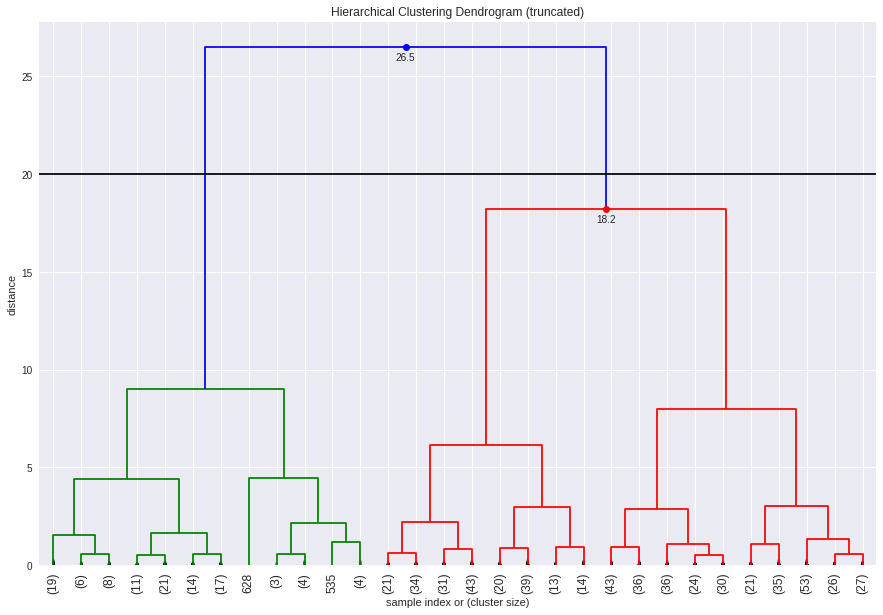

In [51]:
student_df1=student_df.loc[student_df.DIFFICULTY_FLAG == 'HIGH']
student_df1=student_df1.groupby(['STUDENT_ID'])['TOTAL_TIME'].mean().reset_index()
student_df1=student_df1.rename(columns={'TOTAL_TIME':'TOTAL_TIME_DIFFICULT'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(student_df1[['TOTAL_TIME_DIFFICULT']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=20
)

plt.show()

In [52]:
max_d = 20

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

student_df1['TOTAL_TIME_DIFFICULT_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE TOTAL TIME: {}'.format(round(student_df1[student_df1['TOTAL_TIME_DIFFICULT_CLUSTER'] == i].TOTAL_TIME_DIFFICULT.mean(), 2)))

Clusters Summary


label: 1
n: 109
AVERAGE TOTAL TIME: 211.95

label: 2
n: 546
AVERAGE TOTAL TIME: 92.91


In [0]:
student_df1.loc[student_df1['TOTAL_TIME_DIFFICULT_CLUSTER'] == 1, 'TOTAL_TIME_DIFFICULT_FLAG'] = 'HIGH'
student_df1.loc[student_df1['TOTAL_TIME_DIFFICULT_CLUSTER'] == 2, 'TOTAL_TIME_DIFFICULT_FLAG'] = 'LOW'

### 2. By total time in easy questions

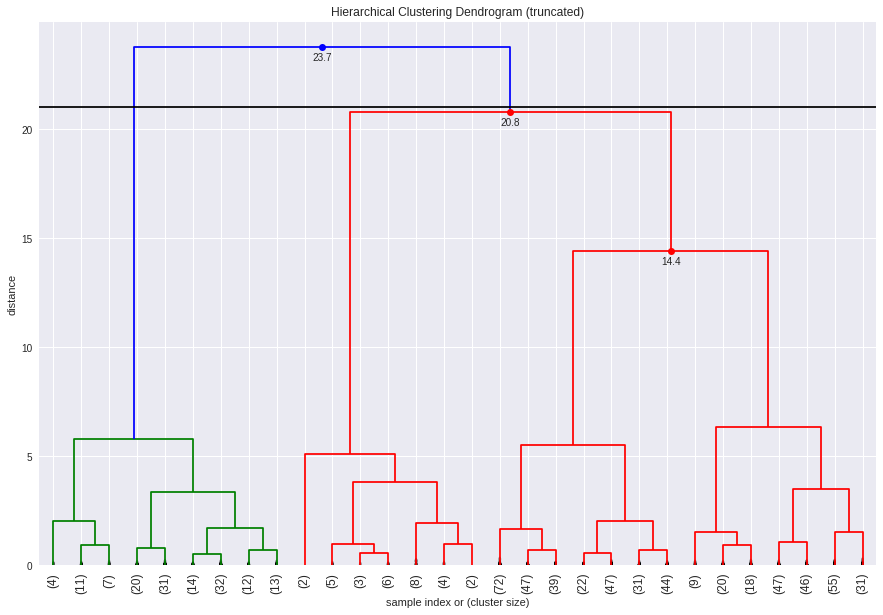

In [54]:
valuelist = question_df_all['QUESTION_ID']
#student_df2=student_df.loc[(student_df.DIFFICULTY_FLAG == 'LOW') & (student_df.STROKE_COUNT_CORRECT_FLAG.isin(valuelist))
student_df2=student_df.loc[(student_df.DIFFICULTY_FLAG == 'LOW')]
student_df2=student_df.groupby(['STUDENT_ID'])['TOTAL_TIME'].mean().reset_index()
student_df2=student_df2.rename(columns={'TOTAL_TIME':'TOTAL_TIME_EASY'})

scaler = StandardScaler()
temp_scaled = scaler.fit_transform(student_df2[['TOTAL_TIME_EASY']])

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=21
)

plt.show()

In [55]:
max_d = 21

clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

student_df2['TOTAL_TIME_EASY_CLUSTER'] = clusters

print('Clusters Summary\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('AVERAGE TOTAL TIME: {}'.format(round(student_df2[student_df2['TOTAL_TIME_EASY_CLUSTER'] == i].TOTAL_TIME_EASY.mean(), 2)))

Clusters Summary


label: 1
n: 144
AVERAGE TOTAL TIME: 59.19

label: 2
n: 558
AVERAGE TOTAL TIME: 113.04


In [0]:
student_df2.loc[student_df2['TOTAL_TIME_EASY_CLUSTER'] == 1, 'TOTAL_TIME_EASY_FLAG'] = 'LOW'
student_df2.loc[student_df2['TOTAL_TIME_EASY_CLUSTER'] == 2, 'TOTAL_TIME_EASY_FLAG'] = 'HIGH'